<a href="https://colab.research.google.com/github/AtSourav/AE-w.-Bottleneck-Residual-Blocks/blob/main/AE_cifar10_residual_blocks_m3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a bigger model than m0-m2, and we shall try increasing the latent dim.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow import math
import tensorflow_datasets as tfds
from keras import losses
from keras import layers
from keras import utils
from keras import metrics
from keras import backend as K
from keras import initializers

import os
import random
import matplotlib.pyplot as plt

In [2]:
! git clone https://github.com/AtSourav/AE-w.-Bottleneck-Residual-Blocks

%cd "/content/AE-w.-Bottleneck-Residual-Blocks"

import Residual_blocks as resblock

Cloning into 'AE-w.-Bottleneck-Residual-Blocks'...
remote: Enumerating objects: 187, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 187 (delta 7), reused 0 (delta 0), pack-reused 168
Receiving objects: 100% (187/187), 6.23 MiB | 11.62 MiB/s, done.
Resolving deltas: 100% (88/88), done.
/content/AE-w.-Bottleneck-Residual-Blocks


# **Latent dim 512**

In [25]:
img_ht = 32
img_wd = 32

input_size = (img_ht,img_wd,3)
latent_dim = 512
batch_size = 128

initializer = initializers.HeNormal(seed=123)

### **Loading the dataset**

In [5]:
ds = tfds.load('cifar10', split='train')
ds2= tfds.load('cifar10', split='test')

ds_to_np = list(ds.as_numpy_iterator())
ds2_to_np = list(ds2.as_numpy_iterator())

img_train = np.array([x['image'] for x in ds_to_np])
img_valid = np.array([x['image'] for x in ds2_to_np])

img_train = img_train/255
img_valid = img_valid/255

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteVEWRPO/cifar10-train.tfrecord*...:   0%|          …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteVEWRPO/cifar10-test.tfrecord*...:   0%|          |…

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


### **Defining the model**

In [26]:
encoder_input = keras.Input(shape=input_size)

x = resblock.bridge_residual_conv2D_block(64, 2, 3, initializer, 'min')(encoder_input)

#####################################################################################

# the default padding is 'valid'

x = resblock.bridge_residual_conv2D_block(128, 2, 3, initializer, 'min')(x)

x = resblock.residual_conv2D_block(128, 2, 3, initializer, 'min', padding = 'same')(x)

x = resblock.residual_conv2D_block(128, 1, 1, initializer, 'min')(x)

#####################################################################################

x = layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid")(x)

#####################################################################################

x = resblock.bridge_residual_conv2D_block(256, 2, 3, initializer, 'min')(x)

x = resblock.residual_conv2D_block(256, 1, 1, initializer, 'min')(x)

x = resblock.residual_conv2D_block(256, 2, 3, initializer, 'min', padding = 'same')(x)

x = resblock.residual_conv2D_block(256, 1, 1, initializer, 'min')(x)

#####################################################################################

x = layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid")(x)

#####################################################################################

x = resblock.bridge_residual_conv2D_block(512, 2, 3, initializer, 'min', padding = 'same')(x)

x = resblock.residual_conv2D_block(512, 1, 1, initializer, 'min')(x)

x = resblock.residual_conv2D_block(512, 2, 3, initializer, 'min', padding = 'same')(x)

x = resblock.residual_conv2D_block(512, 1, 1, initializer, 'min')(x)

#####################################################################################

x = layers.Flatten()(x)

x = layers.Dense(2*latent_dim)(x)
x = layers.ReLU()(x)


z = layers.Dense(latent_dim, name="z")(x)

encoder = keras.Model(encoder_input, z, name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 bridge_residual_conv2d_blo  (None, 28, 28, 64)        39488     
 ck_7 (bridge_residual_conv                                      
 2D_block)                                                       
                                                                 
 bridge_residual_conv2d_blo  (None, 24, 24, 128)       230784    
 ck_8 (bridge_residual_conv                                      
 2D_block)                                                       
                                                                 
 residual_conv2d_block_11 (  (None, 24, 24, 128)       296192    
 residual_conv2D_block)                                          
                                                           

In [27]:
latent_input = keras.Input(shape=(latent_dim,))

x = layers.Dense(2*latent_dim)(latent_input)
x = layers.ReLU()(x)

x = layers.Dense(4*latent_dim)(x)
x = layers.ReLU()(x)

x = layers.Dense(2*2*1024)(x)
x = layers.ReLU()(x)

x = layers.Reshape((2,2,1024))(x)

x = resblock.bridge_residual_conv2Dtrans_block(1024, 1, 1, initializer)(x)

##############################################################################################

x = resblock.bridge_residual_conv2Dtrans_block(512, 1, 1, initializer)(x)

x = resblock.residual_conv2Dtrans_block(512, 2, 3, initializer, padding='same')(x)

x = resblock.bridge_residual_conv2Dtrans_block(512, 1, 1, initializer)(x)

x = resblock.residual_conv2Dtrans_block(512, 2, 3, initializer)(x)

#############################################################################################

x = resblock.bridge_residual_conv2Dtrans_block(256, 1, 1, initializer)(x)

x = resblock.residual_conv2Dtrans_block(256, 2, 3, initializer, padding='same')(x)

x = resblock.residual_conv2Dtrans_block(256, 1, 1, initializer)(x)

x = resblock.residual_conv2Dtrans_block(256, 2, 3, initializer)(x)

#############################################################################################

x = layers.UpSampling2D(size=(2, 2), data_format=None, interpolation='bilinear')(x)

#############################################################################################

x = resblock.bridge_residual_conv2Dtrans_block(128, 2, 3, initializer, padding='same')(x)

x = resblock.residual_conv2Dtrans_block(128, 2, 3, initializer, padding='same')(x)

############################################################################################

x = layers.UpSampling2D(size=(2, 2), data_format=None, interpolation='bilinear')(x)

###########################################################################################

x = resblock.bridge_residual_conv2D_block(128, 2, 3, initializer, 'min')(x)

x = resblock.residual_conv2D_block(128, 1, 1, initializer, 'min')(x)

###########################################################################################

x = resblock.bridge_residual_conv2D_block(64, 1, 2, initializer, 'min')(x)

x = resblock.residual_conv2D_block(64, 1, 2, initializer, 'min')(x)

###########################################################################################

x = resblock.bridge_residual_conv2D_block(32, 1, 2, initializer, 'min')(x)

x = resblock.residual_conv2D_block(32, 1, 2, initializer, 'min')(x)

###########################################################################################

decoder_output = layers.Conv2D(3, 1, activation='sigmoid', padding='valid', kernel_initializer=initializer)(x)

decoder = keras.Model(latent_input, decoder_output, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 512)]             0         
                                                                 
 dense_5 (Dense)             (None, 1024)              525312    
                                                                 
 re_lu_87 (ReLU)             (None, 1024)              0         
                                                                 
 dense_6 (Dense)             (None, 2048)              2099200   
                                                                 
 re_lu_88 (ReLU)             (None, 2048)              0         
                                                                 
 dense_7 (Dense)             (None, 4096)              8392704   
                                                                 
 re_lu_89 (ReLU)             (None, 4096)              0   

In [28]:
decoder_out = decoder(encoder(encoder_input))
AE = keras.Model(encoder_input, decoder_out, name='AE')

AE.summary()


Model: "AE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 encoder (Functional)        (None, 512)               20662848  
                                                                 
 decoder (Functional)        (None, 32, 32, 3)         28017155  
                                                                 
Total params: 48680003 (185.70 MB)
Trainable params: 48655811 (185.61 MB)
Non-trainable params: 24192 (94.50 KB)
_________________________________________________________________


### **Training**

In [9]:
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3, verbose=1, start_from_epoch=10, restore_best_weights=True)
optim = keras.optimizers.Adam(learning_rate = 0.0001)
AE.compile(optimizer=optim,loss='mse', metrics=['accuracy'])
history = AE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=80, callbacks=[callback])

Epoch 1/80
391/391 [==============================] - 106s 162ms/step - loss: 0.0359 - accuracy: 0.4847 - val_loss: 0.0294 - val_accuracy: 0.4710
Epoch 2/80
391/391 [==============================] - 57s 145ms/step - loss: 0.0223 - accuracy: 0.5301 - val_loss: 0.0255 - val_accuracy: 0.5661
Epoch 3/80
391/391 [==============================] - 56s 144ms/step - loss: 0.0186 - accuracy: 0.5848 - val_loss: 0.0195 - val_accuracy: 0.5897
Epoch 4/80
391/391 [==============================] - 56s 144ms/step - loss: 0.0170 - accuracy: 0.6061 - val_loss: 0.0186 - val_accuracy: 0.6072
Epoch 5/80
391/391 [==============================] - 56s 144ms/step - loss: 0.0157 - accuracy: 0.6128 - val_loss: 0.0176 - val_accuracy: 0.6133
Epoch 6/80
391/391 [==============================] - 56s 144ms/step - loss: 0.0149 - accuracy: 0.6202 - val_loss: 0.0160 - val_accuracy: 0.6114
Epoch 7/80
391/391 [==============================] - 56s 144ms/step - loss: 0.0144 - accuracy: 0.6241 - val_loss: 0.0159 - val_a

In [10]:
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3, verbose=1, start_from_epoch=1, restore_best_weights=True)
optim = keras.optimizers.Adam(learning_rate = 0.00001)
AE.compile(optimizer=optim,loss='mse', metrics=['accuracy'])
history2 = AE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=40, callbacks=[callback])

Epoch 1/40
391/391 [==============================] - 90s 153ms/step - loss: 0.0054 - accuracy: 0.7520 - val_loss: 0.0081 - val_accuracy: 0.7463
Epoch 2/40
391/391 [==============================] - 57s 145ms/step - loss: 0.0054 - accuracy: 0.7520 - val_loss: 0.0082 - val_accuracy: 0.7455
Epoch 3/40
391/391 [==============================] - 58s 148ms/step - loss: 0.0054 - accuracy: 0.7519 - val_loss: 0.0082 - val_accuracy: 0.7444
Epoch 4/40
391/391 [==============================] - 56s 144ms/step - loss: 0.0053 - accuracy: 0.7522 - val_loss: 0.0083 - val_accuracy: 0.7404
Epoch 5/40
391/391 [==============================] - 58s 149ms/step - loss: 0.0053 - accuracy: 0.7526 - val_loss: 0.0083 - val_accuracy: 0.7400
Epoch 6/40
391/391 [==============================] - 57s 145ms/step - loss: 0.0053 - accuracy: 0.7526 - val_loss: 0.0083 - val_accuracy: 0.7439
Epoch 7/40
391/391 [==============================] - 58s 149ms/step - loss: 0.0053 - accuracy: 0.7525 - val_loss: 0.0082 - val_ac

It has probably started to overtrain on the training set. If we'd used val_loss as the callback monitor then training would have stopped already.

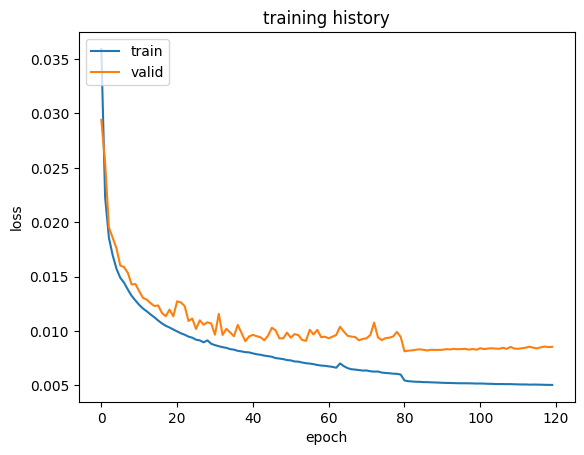

In [11]:
plt.plot(history.history['loss']+history2.history['loss'])
plt.plot(history.history['val_loss']+history2.history['val_loss'])

plt.title('training history')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.legend(['train','valid'], loc='upper left')

plt.show()

### **Reconstructions using above**

In [18]:
def plot_reconstruction(set, name,seed_val, epochs, scale):     #name should be either 'training' or 'validation'
                                                                #scale decides how big the images are
  np.random.seed(seed_val)

  tg_indices = np.random.randint(0,set.shape[0],size = 16)
  img_sample = tf.convert_to_tensor(np.array(set)[tg_indices])
  z_sample = encoder(img_sample)
  img_recon = decoder(z_sample)

  recon = plt.figure(figsize=(np.ceil(9*scale),np.ceil(4*scale)))
  recon.suptitle('Reconstructed images (right) from the ' + name + '-set after ' + str(epochs) + ' epochs: no regularisation in the encoder, decoder, latent_dim =' + str(latent_dim), fontweight= 'bold', y=0.93)

  recon.tight_layout()

  for i in range(36):
    recon.add_subplot(4,9,i+1)
    j = int(np.floor(i/9))
    if (i%9) <4:
      img = set[tg_indices[j*4 + (i%9)]]
      plt.imshow(img)
      plt.axis('off')
    elif (i%9)==4:
      img = np.ones((32,32,3))
      plt.imshow(img)
      plt.axis('off')
    else:
      img = img_recon[j*4 + (i%9) - 5]
      plt.imshow(img)
      plt.axis('off')

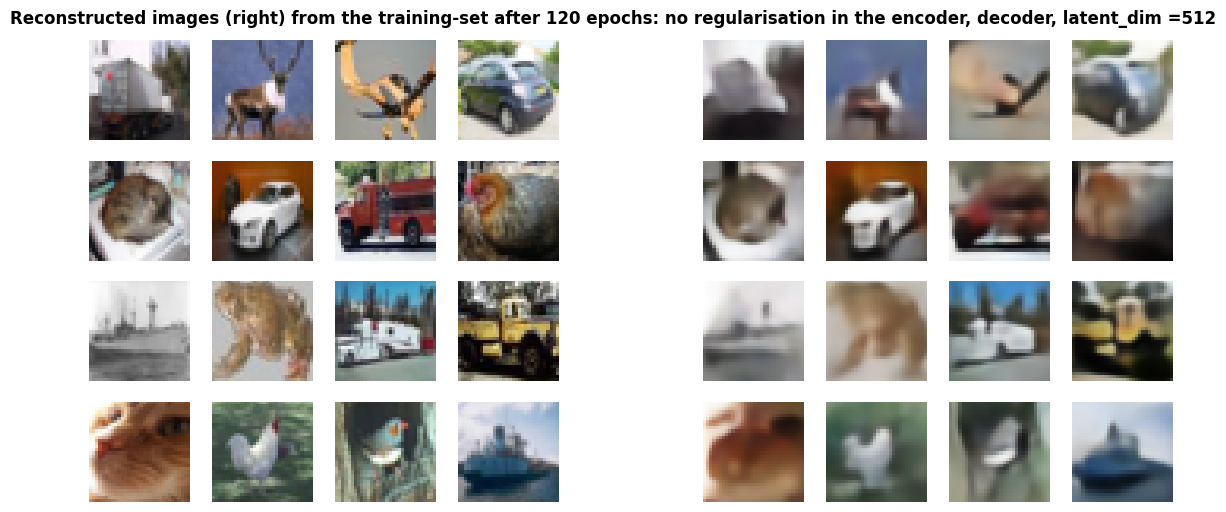

In [19]:
plot_reconstruction(img_train, 'training', 123, 120, 1.5)

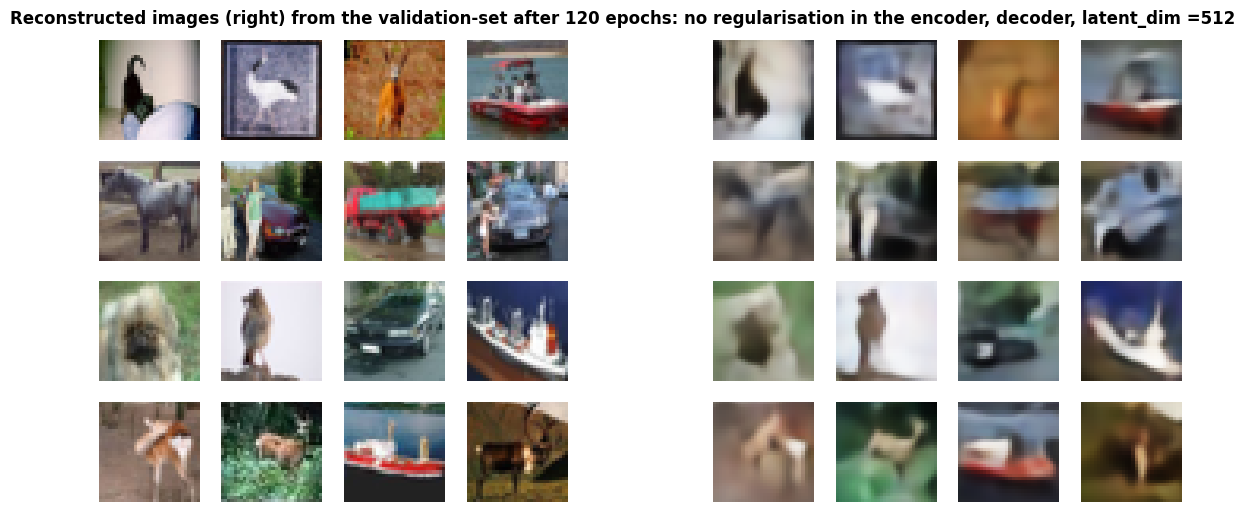

In [20]:
plot_reconstruction(img_valid, 'validation', 123, 120, 1.5)

We got a best training accuracy of over 75% and a best validation set of accuracy of around 74% in the above.

# **Laten dim 384**

In [29]:
K.clear_session()

latent_dim = 384              # half-way between 256 and 512

### **The model**

In [32]:
encoder_input = keras.Input(shape=input_size)

x = resblock.bridge_residual_conv2D_block(64, 2, 3, initializer, 'min')(encoder_input)

#####################################################################################

# the default padding is 'valid'

x = resblock.bridge_residual_conv2D_block(128, 2, 3, initializer, 'min')(x)

x = resblock.residual_conv2D_block(128, 2, 3, initializer, 'min', padding = 'same')(x)

x = resblock.residual_conv2D_block(128, 1, 1, initializer, 'min')(x)

#####################################################################################

x = layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid")(x)

#####################################################################################

x = resblock.bridge_residual_conv2D_block(256, 2, 3, initializer, 'min')(x)

x = resblock.residual_conv2D_block(256, 1, 1, initializer, 'min')(x)

x = resblock.residual_conv2D_block(256, 2, 3, initializer, 'min', padding = 'same')(x)

x = resblock.residual_conv2D_block(256, 1, 1, initializer, 'min')(x)

#####################################################################################

x = layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid")(x)

#####################################################################################

x = resblock.bridge_residual_conv2D_block(512, 2, 3, initializer, 'min', padding = 'same')(x)

x = resblock.residual_conv2D_block(512, 1, 1, initializer, 'min')(x)

x = resblock.residual_conv2D_block(512, 2, 3, initializer, 'min', padding = 'same')(x)

x = resblock.residual_conv2D_block(512, 1, 1, initializer, 'min')(x)

#####################################################################################

x = layers.Flatten()(x)

x = layers.Dense(2*latent_dim)(x)
x = layers.ReLU()(x)


z = layers.Dense(latent_dim, name="z")(x)

encoder = keras.Model(encoder_input, z, name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 bridge_residual_conv2d_blo  (None, 28, 28, 64)        39488     
 ck (bridge_residual_conv2D                                      
 _block)                                                         
                                                                 
 bridge_residual_conv2d_blo  (None, 24, 24, 128)       230784    
 ck_1 (bridge_residual_conv                                      
 2D_block)                                                       
                                                                 
 residual_conv2d_block (res  (None, 24, 24, 128)       296192    
 idual_conv2D_block)                                             
                                                           

In [33]:
latent_input = keras.Input(shape=(latent_dim,))

x = layers.Dense(2*latent_dim)(latent_input)
x = layers.ReLU()(x)

x = layers.Dense(4*latent_dim)(x)
x = layers.ReLU()(x)

x = layers.Dense(2*2*1024)(x)
x = layers.ReLU()(x)

x = layers.Reshape((2,2,1024))(x)

x = resblock.bridge_residual_conv2Dtrans_block(1024, 1, 1, initializer)(x)

##############################################################################################

x = resblock.bridge_residual_conv2Dtrans_block(512, 1, 1, initializer)(x)

x = resblock.residual_conv2Dtrans_block(512, 2, 3, initializer, padding='same')(x)

x = resblock.bridge_residual_conv2Dtrans_block(512, 1, 1, initializer)(x)

x = resblock.residual_conv2Dtrans_block(512, 2, 3, initializer)(x)

#############################################################################################

x = resblock.bridge_residual_conv2Dtrans_block(256, 1, 1, initializer)(x)

x = resblock.residual_conv2Dtrans_block(256, 2, 3, initializer, padding='same')(x)

x = resblock.residual_conv2Dtrans_block(256, 1, 1, initializer)(x)

x = resblock.residual_conv2Dtrans_block(256, 2, 3, initializer)(x)

#############################################################################################

x = layers.UpSampling2D(size=(2, 2), data_format=None, interpolation='bilinear')(x)

#############################################################################################

x = resblock.bridge_residual_conv2Dtrans_block(128, 2, 3, initializer, padding='same')(x)

x = resblock.residual_conv2Dtrans_block(128, 2, 3, initializer, padding='same')(x)

############################################################################################

x = layers.UpSampling2D(size=(2, 2), data_format=None, interpolation='bilinear')(x)

###########################################################################################

x = resblock.bridge_residual_conv2D_block(128, 2, 3, initializer, 'min')(x)

x = resblock.residual_conv2D_block(128, 1, 1, initializer, 'min')(x)

###########################################################################################

x = resblock.bridge_residual_conv2D_block(64, 1, 2, initializer, 'min')(x)

x = resblock.residual_conv2D_block(64, 1, 2, initializer, 'min')(x)

###########################################################################################

x = resblock.bridge_residual_conv2D_block(32, 1, 2, initializer, 'min')(x)

x = resblock.residual_conv2D_block(32, 1, 2, initializer, 'min')(x)

###########################################################################################

decoder_output = layers.Conv2D(3, 1, activation='sigmoid', padding='valid', kernel_initializer=initializer)(x)

decoder = keras.Model(latent_input, decoder_output, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 384)]             0         
                                                                 
 dense_1 (Dense)             (None, 768)               295680    
                                                                 
 re_lu_25 (ReLU)             (None, 768)               0         
                                                                 
 dense_2 (Dense)             (None, 1536)              1181184   
                                                                 
 re_lu_26 (ReLU)             (None, 1536)              0         
                                                                 
 dense_3 (Dense)             (None, 4096)              6295552   
                                                                 
 re_lu_27 (ReLU)             (None, 4096)              0   

In [34]:
decoder_out = decoder(encoder(encoder_input))
AE = keras.Model(encoder_input, decoder_out, name='AE')

AE.summary()


Model: "AE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 encoder (Functional)        (None, 384)               18335936  
                                                                 
 decoder (Functional)        (None, 32, 32, 3)         24772355  
                                                                 
Total params: 43108291 (164.45 MB)
Trainable params: 43084099 (164.35 MB)
Non-trainable params: 24192 (94.50 KB)
_________________________________________________________________


### **Training**

In [35]:
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3, verbose=1, start_from_epoch=10, restore_best_weights=True)
optim = keras.optimizers.Adam(learning_rate = 0.0001)
AE.compile(optimizer=optim,loss='mse', metrics=['accuracy'])
history = AE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=80, callbacks=[callback])

Epoch 1/80
391/391 [==============================] - 91s 153ms/step - loss: 0.0354 - accuracy: 0.4807 - val_loss: 0.0285 - val_accuracy: 0.4730
Epoch 2/80
391/391 [==============================] - 58s 148ms/step - loss: 0.0220 - accuracy: 0.5360 - val_loss: 0.0260 - val_accuracy: 0.5623
Epoch 3/80
391/391 [==============================] - 56s 143ms/step - loss: 0.0183 - accuracy: 0.5818 - val_loss: 0.0193 - val_accuracy: 0.5958
Epoch 4/80
391/391 [==============================] - 56s 143ms/step - loss: 0.0169 - accuracy: 0.6027 - val_loss: 0.0188 - val_accuracy: 0.6065
Epoch 5/80
391/391 [==============================] - 56s 143ms/step - loss: 0.0156 - accuracy: 0.6101 - val_loss: 0.0184 - val_accuracy: 0.6018
Epoch 6/80
391/391 [==============================] - 58s 148ms/step - loss: 0.0149 - accuracy: 0.6158 - val_loss: 0.0156 - val_accuracy: 0.6265
Epoch 7/80
391/391 [==============================] - 56s 143ms/step - loss: 0.0143 - accuracy: 0.6214 - val_loss: 0.0151 - val_ac

In [36]:
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3, verbose=1, start_from_epoch=1, restore_best_weights=True)
optim = keras.optimizers.Adam(learning_rate = 0.00005)
AE.compile(optimizer=optim,loss='mse', metrics=['accuracy'])
history2 = AE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=20, callbacks=[callback])

Epoch 1/20
391/391 [==============================] - 91s 150ms/step - loss: 0.0056 - accuracy: 0.7509 - val_loss: 0.0085 - val_accuracy: 0.7438
Epoch 2/20
391/391 [==============================] - 58s 148ms/step - loss: 0.0056 - accuracy: 0.7515 - val_loss: 0.0085 - val_accuracy: 0.7469
Epoch 3/20
391/391 [==============================] - 58s 148ms/step - loss: 0.0055 - accuracy: 0.7517 - val_loss: 0.0088 - val_accuracy: 0.7383
Epoch 4/20
391/391 [==============================] - 58s 148ms/step - loss: 0.0055 - accuracy: 0.7515 - val_loss: 0.0088 - val_accuracy: 0.7369
Epoch 5/20
391/391 [==============================] - 58s 148ms/step - loss: 0.0055 - accuracy: 0.7515 - val_loss: 0.0088 - val_accuracy: 0.7430
Epoch 6/20
391/391 [==============================] - 58s 148ms/step - loss: 0.0055 - accuracy: 0.7517 - val_loss: 0.0092 - val_accuracy: 0.7289
Epoch 7/20
391/391 [==============================] - 58s 148ms/step - loss: 0.0055 - accuracy: 0.7528 - val_loss: 0.0090 - val_ac

In [ ]:
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3, verbose=1, start_from_epoch=1, restore_best_weights=True)
optim = keras.optimizers.Adam(learning_rate = 0.00001)
AE.compile(optimizer=optim,loss='mse', metrics=['accuracy'])
history3 = AE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=20, callbacks=[callback])